In [1]:
import numpy as np
import random
import math


# 입력 데이터

X = np.array([
    [0.697, 0.460], [0.774, 0.376], [0.634, 0.264], [0.608, 0.318],
    [0.556, 0.215], [0.403, 0.237], [0.481, 0.149], [0.437, 0.211],
    [0.666, 0.091], [0.243, 0.267], [0.245, 0.057], [0.343, 0.099],
    [0.639, 0.161], [0.657, 0.198], [0.360, 0.370], [0.593, 0.042],
    [0.719, 0.103], [0.359, 0.188], [0.339, 0.241], [0.282, 0.257],
    [0.748, 0.232], [0.714, 0.346], [0.483, 0.312], [0.478, 0.437],
    [0.525, 0.369], [0.751, 0.489], [0.532, 0.472], [0.473, 0.376],
    [0.725, 0.445], [0.446, 0.459],
    ])              # 샘플 세트 D

n_components = 3    # 가우시안 혼합 성분 개수 k
epsilon = 1e-3        # 우도 함수 업데이트에 대한 임계값
max_iter = 50         # 최대 반복 횟수
random_state = 42     # 고정 seed

In [2]:
# 과정

# 모델 파라미터 초기화

# 평균
random.seed(random_state)                               # 재현성을 위한 seed 고정
idx = random.sample(range(X.shape[0]), n_components)    # 주어진 범위에서 중복 없이 k (n_components)개의 무작위 샘플을 선택
mu = X[idx,:]                                           # 평균 벡터 mu 초기화

# 공분산
cov_list = []
for _ in range(n_components):
    np.random.seed(random_state)
    arr = np.random.rand(X.shape[1]**2) + 0.1                   # 입력 데이터의 차원 수의 제곱 크기 (4)의 난수를 생성 (0 ~ 1)
                                                                # 공분산 행렬의 대각 성분이 너무 작아지는 것을 방지하기 위해 + 0.1 실행

    temp_mat = np.triu(arr.reshape(X.shape[1], X.shape[1]))     # 입력 데이터의 차원 크기에 맞게 정사각 행렬로 변환한 뒤
                                                                # 정사각 행렬의 윗삼각 행렬을 생성

    cov_elem = temp_mat.dot(temp_mat.T)                         # 양의 정부호 행렬(공분산 행렬)을 생성
                                                                # 공분산 행렬의 특성을 만족시키기 위함

    cov_list.append(cov_elem)

cov_mat = np.array(cov_list)                                    # 공분산 벡터 행렬 sigma 초기화

# 혼합 성분의 선택 확률
weights = np.array([1/n_components] * n_components)             # 혼합 계수 alpha 초기화

In [3]:
## 교재와 동일한 결과를 얻고자 할 경우
## 해당 셀의 코드 실행

# 초기 평균 벡터 및 공분산 행렬 동기화

idx = [i-1 for i in [6, 22, 27]]
mu = X[idx,:]
cov_mat = np.array([np.array([[0.1, 0.0], [0.0, 0.1]]) for _ in range(3)])

In [4]:
def multivariate_normal_pdf(x, mean, cov):
    """
    다변량 정규 분포의 확률 밀도 함수를 구현.

    Parameters:
    x (ndarray): 확률 밀도 함수를 계산할 점(x)의 위치.
    mean (ndarray): 다변량 정규 분포의 평균 벡터.
    cov (ndarray): 다변량 정규 분포의 공분산 행렬.

    Returns:
    float: x에서의 확률 밀도 함수 값.


    교재 247 페이지 참조

    scipy의 multivariate_normal().pdf()으로 대체 가능

    from scipy.stats import multivariate_normal
    multivariate_normal(mean=mu[k],cov=cov_mat[k]).pdf(d))
    """
    n = len(mean)                                       # 평균 벡터의 길이
    det = np.linalg.det(cov)                            # 공분산 행렬의 행렬식(determinant)
    inv_cov = np.linalg.inv(cov)                        # 공분산 행렬의 역행렬
    norm_const = 1.0 / (np.sqrt((2 * np.pi)**n * det))  # 정규화 상수

    exponent = -0.5 * np.dot(np.dot((x - mean).T, inv_cov), (x - mean))  # 지수 부분

    return norm_const * np.exp(exponent)

In [5]:
objective_value = -np.infty
objective_value_history = []
iteration = 1

while(iteration <= max_iter):       # 최대 반복 횟수에 도달할 때까지 반복
    # EM 알고리즘의 E 단계
    assign_prob = []
    for i,d in enumerate(X):        # x_j가 각 혼합 성분에 의해 생성될 사후확률 계산 (식 9.30)
        assign_prob_temp = []
        for k in range(n_components):
            numerator = weights[k] * multivariate_normal_pdf(x=d, mean=mu[k], cov=cov_mat[k])  # 식 9.30의 분자에 해당하는 부분
            assign_prob_temp.append(numerator)

        assign_prob_temp = np.array(assign_prob_temp)
        assign_prob_temp = assign_prob_temp / np.sum(assign_prob_temp)      # 각 확률을 전체 확률의 합으로 나눠 정규
                                                                            # 각 구성 요소에 대한 확률의 총합이 1로 맞춰짐
        assign_prob.append(assign_prob_temp)

    assign_prob = np.array(assign_prob)


    # EM 알고리즘의 M 단계
    temp_sum = np.sum(assign_prob, axis=0)
    next_weights = []
    next_mu = []
    next_cov_mat = []
    for k in range(n_components):

        # 새로운 평균 벡터 mu' 계산
        mu_numerator = np.sum(np.expand_dims(assign_prob[:, k], axis=1) * X, axis=0)

        # 사후 확률 assign_prob과 각 데이터 x_j를 곱한 값을 더해
        # 새로운 평균 벡터의 분자를 계산


        next_mu_vector = mu_numerator / temp_sum[k]
        # 미리 계산해놓은 사후확률의 합을 나눠주어 새로운 평균 벡터 게산

        next_mu.append(next_mu_vector)


        # 새로운 평균 벡터 sigma' 계산
        t = []
        for i, d in enumerate(X):
            x_diff = d - next_mu_vector                 # 각 데이터 포인트와
                                                        # 새로운 평균 벡터의 차이 계산


            x_diff = np.expand_dims(x_diff, axis=1)     # 새로운 공분산 행렬의
            x_diff_cov = np.dot(x_diff, x_diff.T)       # 분자 계산 (수도코드 8번줄)
            x_diff_term = assign_prob[i][k] * x_diff_cov
            t.append(x_diff_term)

        t = np.array(t)
        cov_numerator = np.sum(t, axis=0)
        next_cov_mat.append(cov_numerator / temp_sum[k])


        # 새로운 혼합 계수 alpha' 계산
        next_weights.append(temp_sum[k] / X.shape[0])



    # 모델 파라미터 mu, sigma, alpha를 mu', sigma', alpha'로 생신 (수도코드 10번줄)
    next_objective_value = 0  # 최대 우도 값을 저장할 변수 선언
    for x in X:
        # 각 데이터 포인트에 대한 최대 우도 계산
        # (248페이지 식 9.32)
        temp = multivariate_normal_pdf(x=d, mean=mu[k], cov=cov_mat[k])
        value = np.log(np.sum([next_weights[k] * temp for k in range(n_components)]))
        next_objective_value += value
    objective_value_history.append(next_objective_value)


    # 반복 종료 조건 확인
    # 우도 함수의 증가량이 매우 작을 때
    if abs(next_objective_value - objective_value) <= epsilon:
        print("break")
        break
    else:    # 종료 조건이 충족하지 않았다면 파라미터를 갱신하고 반복 진행
        weights = next_weights
        mu = next_mu
        cov_mat = next_cov_mat
        objective_value = next_objective_value

    iteration += 1

print("iteration: ", iteration)

iteration:  51


In [6]:
# 수도코드 15번줄
# 식 9.31에 따라 x_j의 클러스터 레이블 lambda_j를 정한다.
labels = [np.argmax(x) for x in assign_prob]

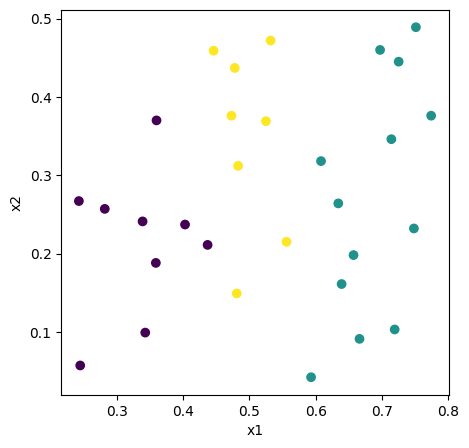

In [7]:
# 시각화

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,5))
fig.set_facecolor('white')
plt.scatter(X[:,0], X[:,1], c=labels)
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()